In [136]:
import spacy
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchmetrics.classification import BinaryF1Score

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

In [8]:
PATH = '../data/text_file.csv'

dataDF = pd.read_csv(PATH)
dataDF.drop('Unnamed: 0', axis = 1, inplace = True)
dataDF


,text,label
0,거미막하강내에서 출혈이 일어나 뇌척수액에 피가 섞인 상태로 지주막하출혈이 라...,1
1,원인질환으로는 중년 이후의 뇌동맥류 파열이 압도적으로 많으며 그밖에 뇌동정맥기형...,1
2,격심한 두통 및 구역질 구토증상이 있으며 의식장애가 나타난다,1
3,타각적으로는 목이 뻣뻣해지는 등 수막자극징후가 인정된다,1
4,재출혈이 일어나는 경우가 많고 특히 발작 후 주 이내는 그 빈도수가 뚜렷하게...,1
...,...,...
2101,속발성 월경곤란증 원인 질환을 치료하면 증상이 소실될 수 있다,0
2102,일반요법 담배는 혈액순환에 장애가 될 수 있으므로 줄이거나 끊도록 권한다,0
2103,알코올은 혈당을 높이는 요인이 되므로 당뇨로 인한 월경곤란증을 경험하는 환자는 음주...,0
2104,적당한 운동과 안정 국소 온열요법은 통증을 감소시키는데 더욱 좋은 효과를 가질 수 있다,0


In [11]:
features = dataDF['text']
target = dataDF['label']

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size = 0.1,
                                                    random_state = 1,
                                                    stratify = target)


In [12]:
# 불용어 처리 (Spacy)

TOKEN_MODEL = 'ko_core_news_lg'

nlp = spacy.load(TOKEN_MODEL)

# Spacy 내장 stopwords가 많지 않아, txt파일로 추가
nlp.Defaults.stop_words

{'가',
 '같',
 '것',
 '그',
 '그것',
 '그러',
 '그러나',
 '그런',
 '그렇',
 '그리고',
 '나',
 '년',
 '놓',
 '다른',
 '더',
 '데',
 '되',
 '두',
 '들',
 '등',
 '때',
 '때문',
 '또',
 '많',
 '말',
 '말하',
 '못하',
 '받',
 '번',
 '보',
 '살',
 '수',
 '시키',
 '싶',
 '아니',
 '안',
 '않',
 '알',
 '어떤',
 '어떻',
 '없',
 '오',
 '원',
 '위하',
 '이',
 '이렇',
 '일',
 '있',
 '잘',
 '점',
 '좀',
 '좋',
 '주',
 '지',
 '크',
 '하',
 '하나',
 '한'}

In [13]:
# 깃허브에 공유되어 있는 한국어 불용어 리스트
STOPWORDS_PATH = '../data/stopwords-ko.txt'

with open(STOPWORDS_PATH) as f:
    stopwords = f.read().split('\n')

# Spacy의 내장 불용어 리스트가 set이므로 중복을 신경쓰지 않고, 바로 추가
for word in stopwords:
    nlp.Defaults.stop_words.add(word)
    
    # 불용어 리스트에 단어를 넣어도, 속성 변경을 하지 않으면 불용어 처리를 하지 않음
    nlp.vocab[word].is_stop = True

In [14]:
# 커스텀 데이터셋 생성
class TextDataset(Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label
        self.n_rows = feature.shape[0]

    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
        return self.feature.iloc[index], self.label.iloc[index]

In [15]:
trainDS = TextDataset(X_train, y_train)
testDS = TextDataset(X_test, y_test)

In [16]:
for feature, label in trainDS:
    print(feature, label)
    break

 때로 무증상일  경우도 있다 0


In [17]:
def generateToken(dataset):
    for text, label in dataset:
        token_list = []
        doc = nlp(text)

        for token in doc:
            if (not token.is_punct) and (not token.is_stop) and (not token.is_space):
                token_list.append(str(token))
        yield token_list

In [19]:
train_token_generator = generateToken(trainDS)
test_token_generator = generateToken(testDS)

In [20]:
# 한번에 많은 양의 데이터를 출력하면, Visual Studio가 꺼지므로, 조금만 출력하기 위한 함수
def check_data(data):
    i = 0
    for _ in data:
        print(_)
        i += 1
        if i == 10:
            break

In [21]:
check_data(train_token_generator)

['때로', '무증상일', '경우도']
['전체', '인구의', '증상을', '가지고', '있으며', '여성이', '남성에', '비하여', '배이상', '많다']
['이담제', '염증성', '산물의', '배설을', '촉진시키기위해', '종근당', '제스탄', '쓴다']
['열이', '없어지면', '목욕이나', '샤워를', '해도', '좋다']
['협심증', '발작을', '일으키기', '쉬우며', '때로는', '심장성', '천식을', '일으키는', '수도']
['도', '정도의', '고열을', '동반하는', '수가', '많으며', '발열이', '일간', '지속된다']
['문맥압항진의', '원인으로는', '간경변증', '등의', '간잘환', '문맥혈전증', '등의', '문맥질환', '비정맥혈전증', '등의', '비장질환', '등을']
['통년성', '또는', '지속성', '알레르기염', '집먼지진드기', '가장', '많이', '생기며', '애완동물', '고양이', '개의', '상피세포', '면사류', '곡식류', '곰팡이류', '등도', '주요', '알레르겐으로', '작용한다']
['분류', '이병변이', '신장에만', '국한된', '일차성과', '전신질환의', '일부분이니', '이차성으로', '나뉜다']
['보통', '감기', '등의', '상기도', '감염이나', '구강내', '처치와', '같은', '일을', '후에', '나타나는', '경우가', '흔하다']


In [22]:
token_freqs = {}

for token_list in train_token_generator:
    for token in token_list:
        if token not in token_freqs:
            token_freqs[token] = 1
        else:
            token_freqs[token] += 1

In [23]:
sorted_tokens = sorted(token_freqs.items(), key = lambda x: x[1], reverse = True)

In [24]:
check_data(sorted_tokens)

('한다', 198)
('경우', 153)
('또는', 93)
('의한', 88)
('증상이', 72)
('것이', 70)
('등의', 67)
('등이', 65)
('가장', 60)
('경우에는', 59)


In [25]:
PAD_TOKEN, OOV_TOKEN = 'pad', 'oov'

vocab = {PAD_TOKEN : 0, OOV_TOKEN : 1}

In [26]:
for index, token in enumerate(sorted_tokens, 2):
    vocab[token[0]] = index

In [27]:
check_data(vocab)

pad
oov
한다
경우
또는
의한
증상이
것이
등의
등이


In [28]:
def numbering(generator):
    encoded_data = []

    for token_list in generator:
        L = []
        for token in token_list:
            if token in vocab:
                L.append(vocab[token])
            else:
                L.append(vocab[OOV_TOKEN])
        encoded_data.append(L)
    return encoded_data

In [29]:
train_token_generator = generateToken(trainDS)
test_token_generator = generateToken(testDS)


In [30]:
train_ids = numbering(train_token_generator)
test_ids = numbering(test_token_generator)

In [31]:
check_data(train_ids)
print()
check_data(test_ids)

[1963, 1, 53]
[494, 1, 81, 6359, 30, 1, 2305, 1, 5411, 31]
[4788, 309, 1, 2151, 1, 1, 1, 179]
[218, 1593, 1, 6074, 1, 97]
[445, 1307, 1247, 4082, 212, 1, 1, 46, 43]
[89, 607, 1, 646, 124, 2917, 1975, 115, 1107]
[1, 285, 1348, 8, 1, 1, 8, 1, 1, 8, 1, 21]
[2942, 4, 1201, 1509, 2329, 10, 20, 1076, 8165, 8166, 980, 8167, 8168, 8169, 8170, 525, 317, 1510, 8171]
[106, 1, 1, 1, 1, 1, 1, 1, 694]
[71, 464, 8, 8045, 5866, 1, 3923, 16, 1360, 138, 45, 22, 6436]

[1, 315]
[1, 1, 6795, 1723, 1, 1, 1, 868, 1, 2728, 1, 1, 1327, 1, 2]
[2396, 1, 848, 172, 1, 1, 6154, 1, 1, 309, 102, 42]
[2097, 1, 183, 411, 1, 1, 9306, 1, 1, 1, 1, 1, 1, 1, 6018, 1]
[1769, 2682, 1, 5061, 7727, 997, 58, 1, 129, 2291, 1, 6436]
[3815, 302, 1, 7108, 1129, 349, 2]
[1507, 1, 1]
[311, 2039, 1023, 254, 4, 272, 21, 1261, 2324, 1, 1, 883, 197, 1, 2516, 190, 1, 372, 459, 8461, 6572]
[290, 52, 1, 178, 1161, 52, 1725, 1]
[1891, 1, 1, 1, 1, 11, 834, 343, 3578]


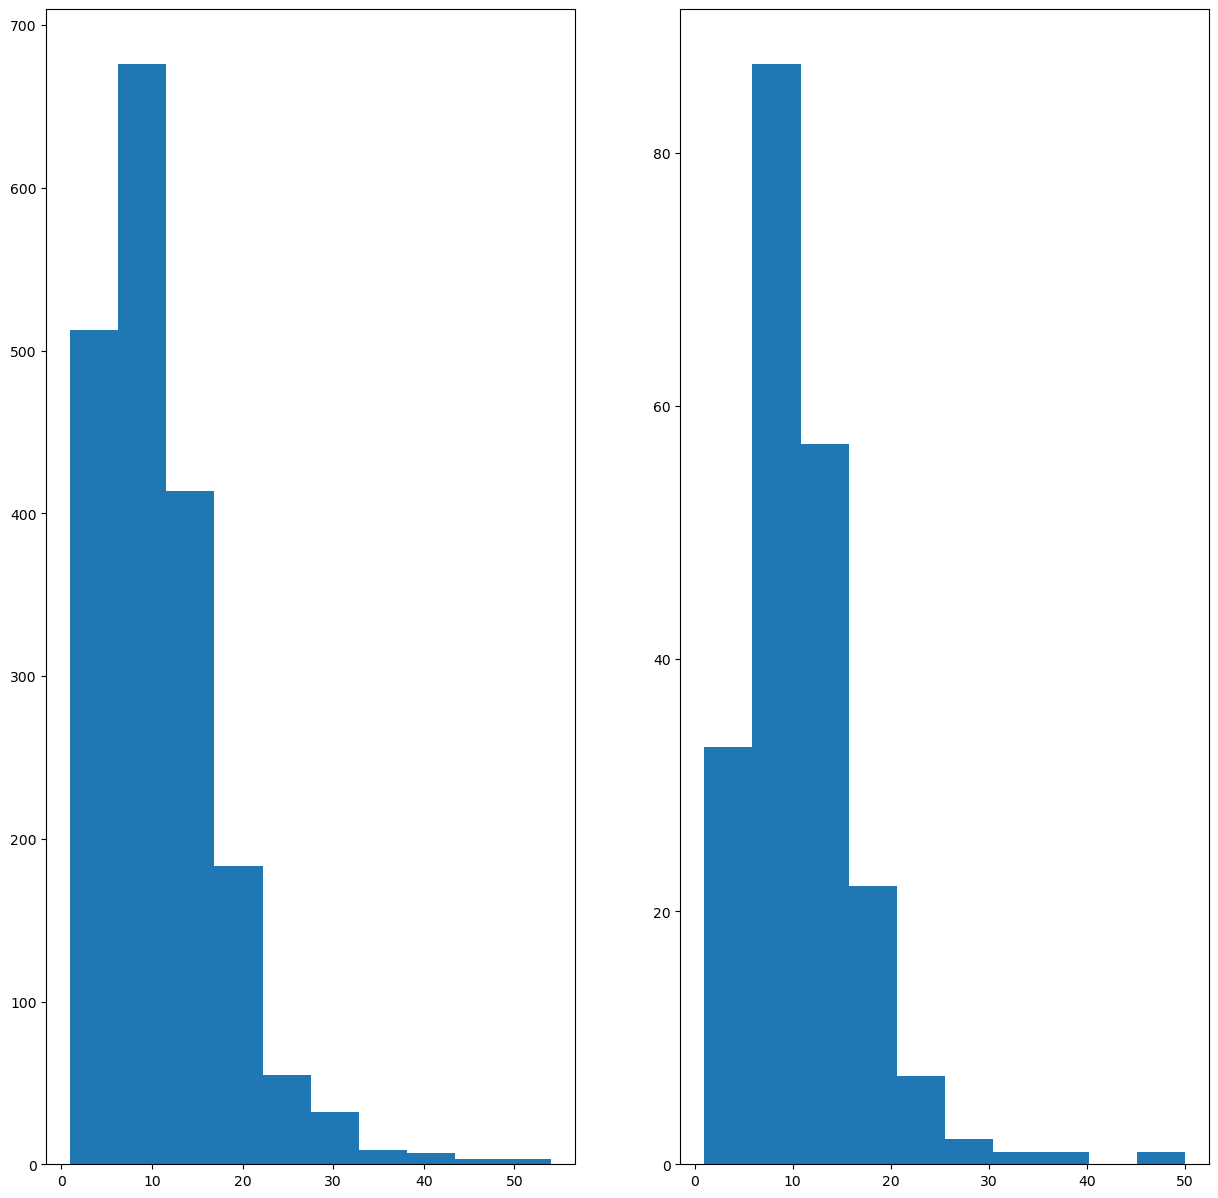

In [42]:
train_data_length = [len(data) for data in train_ids]
test_data_length = [len(data) for data in test_ids]

fig = plt.figure(figsize = (15, 15))
axes = fig.subplots(1, 2)
axes[0].hist(train_data_length)
axes[1].hist(test_data_length)

plt.show()

In [43]:
MAX_LENGTH = 15

def padding(data_ids):
    for index, data in enumerate(data_ids):
        current_length = len(data)
        if current_length < MAX_LENGTH:
            data_ids[index] = data + ([vocab[PAD_TOKEN]] * (MAX_LENGTH - current_length))
        else:
            data_ids[index] = data[ : MAX_LENGTH]

In [44]:
padding(train_ids)
padding(test_ids)

for data in train_ids[:5]:
    print(len(data), data)

print()

for data in test_ids[:5]:
    print(len(data), data)

15 [1963, 1, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
15 [494, 1, 81, 6359, 30, 1, 2305, 1, 5411, 31, 0, 0, 0, 0, 0]
15 [4788, 309, 1, 2151, 1, 1, 1, 179, 0, 0, 0, 0, 0, 0, 0]
15 [218, 1593, 1, 6074, 1, 97, 0, 0, 0, 0, 0, 0, 0, 0, 0]
15 [445, 1307, 1247, 4082, 212, 1, 1, 46, 43, 0, 0, 0, 0, 0, 0]

15 [1, 315, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
15 [1, 1, 6795, 1723, 1, 1, 1, 868, 1, 2728, 1, 1, 1327, 1, 2]
15 [2396, 1, 848, 172, 1, 1, 6154, 1, 1, 309, 102, 42, 0, 0, 0]
15 [2097, 1, 183, 411, 1, 1, 9306, 1, 1, 1, 1, 1, 1, 1, 6018]
15 [1769, 2682, 1, 5061, 7727, 997, 58, 1, 129, 2291, 1, 6436, 0, 0, 0]


In [95]:
# 커스텀 데이터셋 생성
class TextDataset2(Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label
        self.n_rows = feature.shape[0]

    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
        return torch.IntTensor(self.feature.iloc[index]), torch.IntTensor(self.label.iloc[index])

In [96]:
# 수치화를 시긴 데이터로 데이터셋 생성
train_df = pd.DataFrame(train_ids)
y_train = pd.DataFrame(y_train)
test_df = pd.DataFrame(test_ids)
y_test = pd.DataFrame(y_test)

train_dataset = TextDataset2(train_df, y_train)
test_dataset = TextDataset2(test_df, y_test)

In [97]:
test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,315,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,6795,1723,1,1,1,868,1,2728,1,1,1327,1,2
2,2396,1,848,172,1,1,6154,1,1,309,102,42,0,0,0
3,2097,1,183,411,1,1,9306,1,1,1,1,1,1,1,6018
4,1769,2682,1,5061,7727,997,58,1,129,2291,1,6436,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,1,9232,1,5645,1,1,203,774,1,4729,1,4729,6879,1,2518
207,14,9480,3,110,8599,8036,81,479,6066,2617,1,0,0,0,0
208,1,787,8958,1,7465,2122,1186,0,0,0,0,0,0,0,0
209,12,1,266,3,1,7,10,1014,0,0,0,0,0,0,0


In [98]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [82]:
train_token_generator = generateToken(trainDS)
test_token_generator = generateToken(testDS)

In [83]:
train_token_list = []

for token in train_token_generator:
    train_token_list.append(token)

train_token_list[:5]

[['때로', '무증상일', '경우도'],
 ['전체', '인구의', '증상을', '가지고', '있으며', '여성이', '남성에', '비하여', '배이상', '많다'],
 ['이담제', '염증성', '산물의', '배설을', '촉진시키기위해', '종근당', '제스탄', '쓴다'],
 ['열이', '없어지면', '목욕이나', '샤워를', '해도', '좋다'],
 ['협심증', '발작을', '일으키기', '쉬우며', '때로는', '심장성', '천식을', '일으키는', '수도']]

In [99]:
MODEL_PATH = '../models/'

word2vec = Word2Vec(
    sentences = train_token_list,
    vector_size = 128,
    window = 5,
    min_count = 1,
    sg = 0,
    epochs = 30,
    max_final_vocab = None
)

word2vec.save(MODEL_PATH + 'word2vec.model')

In [100]:
## 생성된 모델 확인
word2vec = Word2Vec.load(MODEL_PATH + 'word2vec.model')

word = '호흡'

print(word2vec.wv[word])
print(word2vec.wv.most_similar(word, topn = 5))
print(word2vec.wv.similarity(w1 = word, w2 = '최근'))

[ 7.0178346e-03 -1.7415009e-02  1.2734567e-02  6.9466833e-04
  2.1052739e-02 -1.9261047e-02  1.0189073e-02 -1.0676056e-02
 -1.5981859e-02 -9.8442810e-04  1.9595018e-02  2.3723189e-03
 -6.1482098e-03 -2.3287816e-02  5.3606145e-03  1.1621552e-02
 -1.5604365e-02  4.2904443e-03 -3.4391019e-02  1.5494953e-02
  1.3218078e-02 -6.2542415e-04 -1.7475986e-03 -3.0853201e-02
 -1.6070314e-02  1.5956949e-02 -2.0209180e-02  1.1527786e-02
 -1.2927998e-03 -3.4684024e-03 -6.6028982e-03  5.8202217e-03
  1.1173513e-02  7.9093417e-03 -1.3327443e-02  1.1529320e-02
  1.6077859e-02 -1.8706486e-02  2.9030039e-03  1.0756666e-03
  5.6476854e-03  6.3179065e-03 -7.3078526e-03 -1.5530602e-02
  2.3065804e-02 -5.8714948e-03 -5.0455811e-03 -2.8047913e-03
 -1.4408421e-02  1.0917467e-02  8.7410063e-03 -1.0043499e-02
  1.8357314e-02  2.9392606e-02  9.3169925e-05 -3.1552424e-03
  2.7284360e-02  6.5836376e-03 -1.9971514e-02  7.3003680e-03
 -1.9869536e-02 -3.0684713e-03 -2.2797295e-04 -5.2848379e-03
  2.5838112e-02 -1.59148

In [101]:
# word2vec의 vector_size와 embedding_dim의 크기가 같아야 되는거 같다.

n_vocab = len(vocab)
hidden_dim = 64
embedding_dim = 128
n_layers = 10

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [102]:
# 임베딩 - word2vec의 max_final_vocab을 제한해 버리면,
# sentences 파라미터에 들어가는 토큰 수가 클 수록, 임베딩이 되지 않는 경우가 생김
# 이번엔 제한 없이 했지만, 단어 사전 수를 제한해서 빈도 수가 적은 애들은 
# 메모리를 생각해서 전부 oov로 전환 시키는 것이 좋을 듯 하다.

init_embeddings = np.zeros((n_vocab, embedding_dim))

for token, index in vocab.items():
    if token not in [PAD_TOKEN, OOV_TOKEN]:
        init_embeddings[index] = word2vec.wv[token]

embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(init_embeddings, dtype = torch.float32)
)

In [103]:
check_data(init_embeddings)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.39514503 -0.99020988  0.60180229  0.2802552   1.10267842 -0.91574484
  0.13944748 -0.29138207 -0.42729509  0.32774815  0.65812099 -0.18094005
 -0.1074506  -0.81275052  0.37217569  0.84253895 -0.83167052  0.03079611

In [195]:
# 문장 분류 모델 

class SentenceClassifier(nn.Module):
    def __init__(self,
                 n_vocab,
                 hidden_dim,
                 embedding_dim,
                 n_layers,
                 dropout = 0.5,
                 # 양방향은 빈칸에 들어갈 단어를 고르는 등, 앞 문장과 뒷 문장이 둘 다 중요할 때 사용
                 bidirectional = True,
                 model_type = 'lstm',
                 pretrained_embedding = None
                 ):
        super().__init__()

        if pretrained_embedding is not None:
            self.embedding = nn.Embedding.from_pretrained(
                torch.tensor(pretrained_embedding, dtype = torch.float32)
            )
        else:
            self.embedding = nn.Embedding(
                num_embeddings = n_vocab,
                embedding_dim = embedding_dim,
                padding_idx = 0
        )
        
        if model_type == 'rnn':
            self.model = nn.RNN(
                input_size = embedding_dim,
                hidden_size = hidden_dim,
                num_layers = n_layers,
                bidirectional = bidirectional,
                dropout = dropout,
                batch_first = True
            )
        elif model_type == 'lstm':
            self.model = nn.LSTM(
                input_size = embedding_dim,
                hidden_size = hidden_dim,
                num_layers = n_layers,
                bidirectional = bidirectional,
                dropout = dropout,
                batch_first = True
            )
        
        if bidirectional:
            self.classifier = nn.Sequential(
                nn.Linear(hidden_dim * 2, 200),
                nn.ReLU(),
                nn.Linear(200, 150),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(150, 100),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(100, 50),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(50, 30),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(30, 1)
            )
        
        else:
            self.classifier = nn.Sequential(
                nn.Linear(hidden_dim, 200),
                nn.ReLU(),
                nn.Linear(200, 150),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(150, 100),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(100, 50),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(50, 30),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(30, 1)
            )
        # self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:, -1, :]
        # last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return F.sigmoid(logits)

In [196]:
classifier = SentenceClassifier(
    n_vocab = n_vocab, hidden_dim = hidden_dim, embedding_dim = embedding_dim,
    n_layers = n_layers, pretrained_embedding = init_embeddings
).to(DEVICE)

In [197]:
EPOCH = 100
LR = 0.001

regLoss = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr = LR)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience = 100, verbose = True)


c:\Users\KDP-2\anaconda3\envs\TEXT_018_230_38\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [198]:
def testing(featureDF, targetDF):
    testTS = torch.LongTensor(featureDF.values).to(DEVICE)
    targetTS = torch.FloatTensor(targetDF.values).to(DEVICE)
    
    with torch.no_grad():
        pre_val = classifier(testTS)
        loss_val = regLoss(pre_val, targetTS)
        score_val = BinaryF1Score()(pre_val, targetTS)
        pred_labels = (pre_val >= 0.5).float()

    return loss_val, score_val, pred_labels

In [199]:
SAVE_PATH = './saved_models/'
os.makedirs(SAVE_PATH, exist_ok = True)

def training(valTS, valtargetTS):
    BREAK_CNT_LOSS = 0
    BREAK_CNT_SCORE = 0
    LIMIT_VALUE = 10

    LOSS_HISTORY, SCORE_HISTORY = [[], []], [[], []]

    for epoch in range(EPOCH):
        SAVE_MODEL = os.path.join(SAVE_PATH, f'model_{epoch}.pth')
        SAVE_FILE = os.path.join(SAVE_PATH, f'model_weights_{epoch}.pth')

        loss_total, score_total = 0, 0

        for featureTS, targetTS in train_loader:
            pre_y = classifier(featureTS)
            targetTS = targetTS.float()

            loss = regLoss(pre_y, targetTS)
            loss_total += loss.item()

            score = BinaryF1Score()(pre_y, targetTS)
            
            score_total += score.item()


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss, val_f1, _ = testing(valTS, valtargetTS)
        LOSS_HISTORY[1].append(val_loss)
        SCORE_HISTORY[1].append(val_f1)

        LOSS_HISTORY[0].append(loss_total / len(train_loader))
        SCORE_HISTORY[0].append(score_total / len(train_loader))

        print(f"[{epoch + 1}/{EPOCH}]\n - TRAIN LOSS : {LOSS_HISTORY[0][-1]} F1 : {SCORE_HISTORY[0][-1]}")
        print(f"- VAL LOSS : {LOSS_HISTORY[1][-1]} F1 : {SCORE_HISTORY[1][-1]}")

        scheduler.step(val_f1)

            # 학습 진행 모니터링/스케쥴링 - 검증 DS 기준
        # Score 기준
        if len(SCORE_HISTORY[1]) >= 2:
            if SCORE_HISTORY[1][-1] >= SCORE_HISTORY[1][-2]: BREAK_CNT_SCORE += 1

        # 성능이 좋은 학습 가중치 저장

        if len(SCORE_HISTORY[1]) == 1:
            # 첫 번째라서 무조건 모델 파라미터 저장
            torch.save(classifier.state_dict(), SAVE_FILE)
            # 모델 전체 저장
            torch.save(classifier, SAVE_MODEL)
        else:
            if SCORE_HISTORY[1][-1] > max(SCORE_HISTORY[1][:-1]):
                torch.save(classifier.state_dict(), SAVE_FILE)
                torch.save(classifier, SAVE_MODEL)

        if BREAK_CNT_LOSS > LIMIT_VALUE:
            print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
            break

    return LOSS_HISTORY, SCORE_HISTORY


In [200]:
loss, f1 = training(test_df, y_test)

[1/100]
 - TRAIN LOSS : 0.6930702050526937 F1 : 0.4762906855593125
- VAL LOSS : 0.6928520202636719 F1 : 0.6350364685058594
[2/100]
 - TRAIN LOSS : 0.6917138020197551 F1 : 0.637225001056989
- VAL LOSS : 0.6941144466400146 F1 : 0.644518256187439
[3/100]
 - TRAIN LOSS : 0.6903645793596903 F1 : 0.6852069278558095
- VAL LOSS : 0.6935572624206543 F1 : 0.6708860993385315
[4/100]
 - TRAIN LOSS : 0.6922850410143534 F1 : 0.6677424391110738
- VAL LOSS : 0.6917057037353516 F1 : 0.6132404208183289
[5/100]
 - TRAIN LOSS : 0.6904404679934184 F1 : 0.6668258746465047
- VAL LOSS : 0.6912016868591309 F1 : 0.662162184715271
[6/100]
 - TRAIN LOSS : 0.6888196011384328 F1 : 0.6578293859958648
- VAL LOSS : 0.6935476660728455 F1 : 0.6689895391464233
[7/100]
 - TRAIN LOSS : 0.6861846625804902 F1 : 0.6589838514725367
- VAL LOSS : 0.6926062107086182 F1 : 0.6394051909446716
[8/100]
 - TRAIN LOSS : 0.6912880301475525 F1 : 0.6081008682648341
- VAL LOSS : 0.6947083473205566 F1 : 0.6090225577354431
[9/100]
 - TRAIN LO

In [149]:
for feature, label in train_loader:
    print((classifier(feature) >= 0.5).float())
    break

tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.]])
